<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Compact_Convolutional_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Compact Convolutional Transformers**


As discussed in the Vision Transformers (ViT) paper, a Transformer-based architecture for vision typically requires a larger dataset than usual, as well as a longer pre-training schedule. ImageNet-1k (which has about a million images) is considered to fall under the medium-sized data regime with respect to ViTs. This is primarily because, unlike CNNs, ViTs (or a typical Transformer-based architecture) do not have well-informed inductive biases (such as convolutions for processing images). This begs the question: can't we combine the benefits of convolution and the benefits of Transformers in a single network architecture? These benefits include parameter-efficiency, and self-attention to process long-range and global dependencies (interactions between different regions in an image).


In Escaping the Big Data Paradigm with Compact Transformers, Hassani et al. present an approach for doing exactly this. They proposed the Compact Convolutional Transformer (CCT) architecture. In this example, we will work on an implementation of CCT and we will see how well it performs on the CIFAR-10 dataset.


If you are unfamiliar with the concept of self-attention or Transformers, you can read this chapter from François Chollet's book Deep Learning with Python. This example uses code snippets from another example, Image classification with Vision Transformer.

In [1]:
pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Hyperparameters and constants**

In [3]:
positional_emb = True
conv_layers = 2
projection_dim = 128

num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
image_size = 32

In [4]:
num_classes=10
input_shape = (32,32,3)
(x_train, y_train),(x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170498071/170498071 [==============================] - 2s 0us/step
(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


**The CCT tokenizer**

The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.

We already know that convolutions are quite good at exploiting locality information. So, based on this, the authors introduce an all-convolution mini-network to produce image patches.

In [11]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # This is our tokenizer.
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # After passing the images through our mini-network the spatial dimensions
        # are flattened to form sequences.
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # Positional embeddings are optional in CCT. Here, we calculate
        # the number of sequences and initialize an `Embedding` layer to
        # compute the positional embeddings later.
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

**Stochastic depth for regularization**

Stochastic depth is a regularization technique that randomly drops a set of layers. During inference, the layers are kept as they are. It is very much similar to Dropout but only that it operates on a block of layers rather than individual nodes present inside a layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers encoder.

In [20]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

**MLP for the Transformers encoder**

In [21]:
def mlp(x, hidden_units,  dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation = tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [22]:
data_augmentation = keras.Sequential([
    layers.Rescaling(1./255.0),
    layers.RandomCrop(image_size, image_size),
    layers.RandomFlip("horizontal")
    ])

**The final CCT model**

Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only the feature map corresponding to the class token is pooled and is then used for the subsequent classification task (or any other downstream task). In CCT, outputs from the Transformers encoder are weighted and then passed on to the final task-specific layer (in this example, we do classification).

In [23]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):
    inputs = layers.Input(input_shape)

    # Augment data.
    augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling.
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs.
    logits = layers.Dense(num_classes)(weighted_representation)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

***Model training and evaluation***

In [24]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/30
352/352 [==============================] - 19s 39ms/step - loss: 1.8850 - accuracy: 0.3405 - top-5-accuracy: 0.8474 - val_loss: 1.6442 - val_accuracy: 0.4600 - val_top-5-accuracy: 0.9234
Epoch 2/30
352/352 [==============================] - 13s 36ms/step - loss: 1.5711 - accuracy: 0.5011 - top-5-accuracy: 0.9319 - val_loss: 1.4619 - val_accuracy: 0.5462 - val_top-5-accuracy: 0.9534
Epoch 3/30
352/352 [==============================] - 13s 36ms/step - loss: 1.4352 - accuracy: 0.5703 - top-5-accuracy: 0.9513 - val_loss: 1.3629 - val_accuracy: 0.5982 - val_top-5-accuracy: 0.9626
Epoch 4/30
352/352 [==============================] - 13s 36ms/step - loss: 1.3523 - accuracy: 0.6076 - top-5-accuracy: 0.9604 - val_loss: 1.2845 - val_accuracy: 0.6472 - val_top-5-accuracy: 0.9678
Epoch 5/30
352/352 [==============================] - 13s 36ms/step - loss: 1.2898 - accuracy: 0.6409 - top-5-accuracy: 0.9672 - val_loss: 1.2554 - val_accuracy: 0.6546 - val_top-5-accuracy: 0.9690
Epoch 6/30

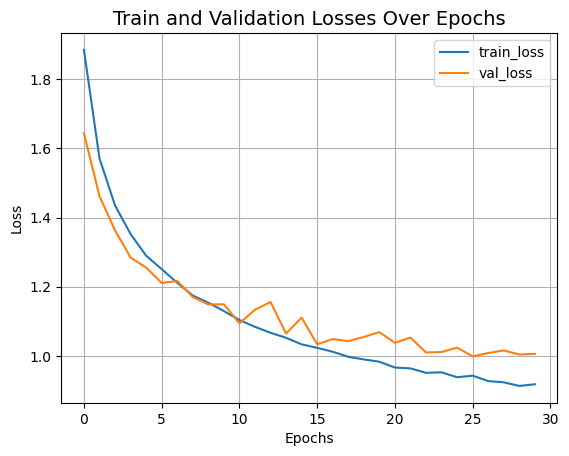

In [25]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


The CCT model we just trained has just 0.4 million parameters, and it gets us to ~78% top-1 accuracy within 30 epochs. The plot above shows no signs of overfitting as well. This means we can train this network for longer (perhaps with a bit more regularization) and may obtain even better performance. This performance can further be improved by additional recipes like cosine decay learning rate schedule, other data augmentation techniques like AutoAugment, MixUp or Cutmix. With these modifications, the authors present 95.1% top-1 accuracy on the CIFAR-10 dataset. The authors also present a number of experiments to study how the number of convolution blocks, Transformers layers, etc. affect the final performance of CCTs.


For a comparison, a ViT model takes about 4.7 million parameters and 100 epochs of training to reach a top-1 accuracy of 78.22% on the CIFAR-10 dataset. You can refer to this notebook to know about the experimental setup.